# Example to get CloudSat mean pressure level profile


# Table of Contents
<ul>
<li><a href="#introduction">1. Introduction</a></li>
<li><a href="#data_wrangling">2. Data Wrangling</a></li>
<li><a href="#exploratory">3. Exploratory Data Analysis</a></li>
<li><a href="#conclusion">4. Conclusion</a></li>
<li><a href="#references">5. References</a></li>
</ul>

# 1. Introduction <a id='introduction'></a>

**Questions**


> **_NOTE:_** The pressure grid created here is used later in the  [Jupyter Notebook](./read_2C_snow.ipynb) to calculate the monthly means of CloudSat variables.

# 2. Data Wrangling <a id='data_wrangling'></a>

This study will retrieve the CloudSat mean pressure grid from the [ECMWF-AUX files](https://www.cloudsat.cira.colostate.edu/data-products/ecmwf-aux). We decided to use the CloudSat overpasses from 2008 as this is the year with the most CloudSat available data. We make use of the `scipy.optimize.curve_fit` function to calculate pressure levels.


- Time period: 2008
- time resolution: daily atmospheric overpasses 
- Variables:
  
|              Long name                   |      Units    |  Dimension |
| :---------------------------------------:| -------------:|--------:|
|    Pressure                              |[Pa]           | nray, nbin |





## Import python packages
- `Python` environment requirements: file [globalsnow.yml](../globalsnow.yml) 
- load `python` packages from [imports.py](../utils/imports.py)
- load `functions` from [functions.py](../utils/functions.py)

In [1]:
import sys
import os
if os.path.isfile('/uio/kant/geo-metos-u1/franzihe/Documents/Python/globalsnow/eosc-nordic-climate-demonstrator/work/utils/imports.py') == True:
    sys.path.append('/uio/kant/geo-metos-u1/franzihe/Documents/Python/globalsnow/eosc-nordic-climate-demonstrator/work/utils')

from imports import(xr, ccrs, cy, plt, glob, fct, np, da, datetime, timedelta, h5py, curve_fit)

In [2]:
# reload imports
%load_ext autoreload
%autoreload 2

## Open CloudSat variables
Get the data requried for the analysis. Beforehand we downloaded the [ECMWF-AUX files](https://www.cloudsat.cira.colostate.edu/data-products/ecmwf-aux) with the script provided on the [CloudSat webpage](https://cswww.cira.colostate.edu/code_library/cloudsat_ftp.plx).



The CloudSat data is located in the folder `/input/CloudSat/` and individual folders for the CloudSat product. The 2C-SNOW-PROFILEs are in `/2C-SNOW-PROFILE.P1_R05/` while the ECMWF-AUX files are in `/ECMWF-AUX.P_R05/`. Each year has extra folders for the day of the year, where all CloudSat granules can be found of that specific day. 


In [3]:
input_data = '/scratch/franzihe/input'
output_data = '/scratch/franzihe/output'

In [4]:
cs_in = '{}/CloudSat/'.format(input_data)
ff_ec = sorted(glob(cs_in+'ECMWF-AUX.P_R05/2008/*/*.h5'))

In [5]:
DATA_VARNAMES_EC = ["Pressure", ]

In [6]:
datasets = []

for file in ff_ec:
    year = int(file.split('/')[-1].split('_')[0][0:4])
    doy = int(file.split('/')[-1].split('_')[0][4:7])  # day of the year
    tt = datetime(year, 1, 1) + timedelta(doy - 1)
    
    for month in range(1, 13):
        if tt.month == month:
            ds = xr.Dataset()
            
            # load ECMWF-AUX file
            h5file = h5py.File(file, "r")

            for var in DATA_VARNAMES_EC:
                ds[var] = fct.get_data_var(h5file['ECMWF-AUX'], var)

            datasets.append(ds)

    ds_cs = xr.concat(datasets,dim='nray')



In [7]:
# convert ECMWF pressure to hPa
ds_cs['Pressure'] = ds_cs['Pressure']/100

# create mean over all granules to create pressure grid
ds_cs['Pressure'] = ds_cs['Pressure'].mean('nray', keep_attrs=True, skipna=True)
ds_cs['Pressure'].attrs = {'units': 'hPa', 'longname':'Pressure'}

In [8]:
# create pressure variable without NaN values
cs_pressure = ds_cs['Pressure'][np.isfinite(ds_cs['Pressure'])]

# find the index where pressure has NaN values 
idx_where_p_nan = ds_cs['Pressure'][~np.isfinite(ds_cs['Pressure'])].nbin

In [9]:
# Generate exponential pressure grid from mean over all granules
fitting_parameters, covariance = curve_fit(f=fct.exponential_fit, xdata=range(len(cs_pressure)), ydata=cs_pressure.values, p0=[1, -1, 0])

# pressure where values were found to be NaN 
# corrected by 15hPa to fit to existing curve (roughly determined via including last point in exponential_fit)
p_where_p_nan = fct.exponential_fit(idx_where_p_nan, fitting_parameters[0], fitting_parameters[1], fitting_parameters[2]) - 15 


# Combine the arrays with pressure levels provided by the ECMWF-AUX file and the ones calculated with the exponential fit
ds_cs['Pressure_grid'] = xr.concat([cs_pressure, p_where_p_nan], dim = 'nbin', coords='minimal')

In [10]:
# Email from Sally:
# Create a linear height array grid to put all the data on    
#     vertical_binsize=240.0  ;m
#     height=vertical_binsize/2.0
vertical_binsize = 240. 
height = vertical_binsize/2
ds_cs['height'] = xr.DataArray(data = np.arange(height,len(ds_cs['Pressure'])*vertical_binsize, vertical_binsize)[::-1], dims = ds_cs.nbin.dims[0], coords=[ds_cs['nbin'].values])
ds_cs['height'].attrs = ({'units':'m', 'longname':'height above ground'})

In [11]:
# The altitude in meters can be calculated with the international barometric formula:

# H = 44330 * [1 - (P/p0)^(1/5.255) ]
height_agl = 44330 * (1 - (ds_cs['Pressure_grid']/1013.25) ** (1/5.255))

# Assign coordinates and attributes to the coordinate as this will be handy for any plotting later
ds_cs['Pressure_grid'] = ds_cs['Pressure_grid'].assign_coords(height_agl=("nbin", height_agl.values))
ds_cs['height_agl'].attrs = ({'units':ds_cs['height'].attrs['units'], 'longname': 'height above ground'}) 

# Round grid values
ds_cs['Pressure_grid'] = ds_cs['Pressure_grid'].round(decimals=0)

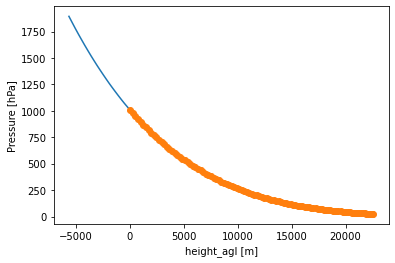

In [12]:
# # Example plot of the new pressure grid retrieved with the exponetial fit and the pressure provided by the ECMWF-AUX file
# ds_cs['Pressure_grid'].plot(x = 'height_agl')
# ds_cs['Pressure'].plot(x = 'height_agl', marker='o')

In [13]:
# Save DataSet to NetCDF
ds_cs.drop(('Pressure', 'nray' )).to_netcdf('{}/CloudSat/ECMWF-AUX.P_R05/pressure_grid.nc'.format(output_data))
print('file written: {}/CloudSat/ECMWF-AUX.P_R05/pressure_grid.nc'.format(output_data))

file written: /scratch/franzihe/output/CloudSat/ECMWF-AUX.P_R05/pressure_grid.nc
